## Kode til FN's verdensmål


### Indlæs pakker

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tools import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# --- Load SDG Index data ---
data_path = r"../data/full_data_set.xlsx"
df = pd.read_excel(data_path, sheet_name="Backdated SDG Index")

# Remove aggregates (ids starting with "_")
df = df[~df["id"].astype(str).str.startswith("_")].copy()

# --- Clean numeric columns (sdgi_s + goals) ---
goal_cols = [c for c in df.columns if c.startswith("goal")]
all_cols = ["sdgi_s"] + goal_cols
for col in all_cols:
    df[col] = df[col].astype(str).str.replace(",", ".").astype(float)

# --- Load population data ---
population_path = r"../data/population_data.xlsx"
df_pop = pd.read_excel(population_path, sheet_name="DATA")

# Reshape into long format
df_pop_long = df_pop.melt(
    id_vars=["Country Name", "Country Code"],
    var_name="year",
    value_name="population"
)
df_pop_long["year"] = pd.to_numeric(df_pop_long["year"], errors="coerce")

start_year, end_year = 2000, 2024

# Extract 2024 only
pop_2024 = df_pop_long[df_pop_long["year"] == end_year][["Country Code", "population"]]

# Split into start and end year
df_start = df[df["year"] == start_year].set_index("id")[all_cols+ ["indexreg_"]]
df_end   = df[df["year"] == end_year].set_index("id")[all_cols]

# --- Build structured DataFrame ---
summary = pd.DataFrame(index=df_start.index)

for col in all_cols:
    summary[f"{col}_start"] = df_start[col]
    summary[f"{col}_rel_change"] = (
        (df_end[col] - df_start[col])
    )
summary["region"] = df_start["indexreg_"]

# Add population
summary = summary.reset_index().merge(
    pop_2024, left_on="id", right_on="Country Code", how="left"
).drop(columns=["Country Code"])

# Force population to float immediately
summary["population"] = pd.to_numeric(summary["population"], errors="coerce").astype(float)

summary = summary.set_index("id")

# Build stable region → code mapping from the full dataset
region_categories = pd.Categorical(summary["region"].dropna()).categories
region_to_code = {region: i for i, region in enumerate(region_categories)}

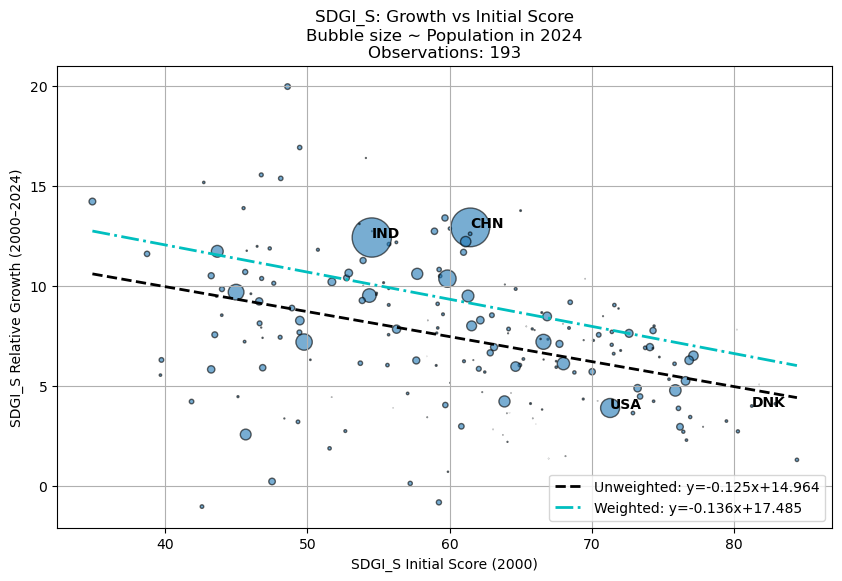

In [29]:
# Build global region mapping once
region_categories = pd.Categorical(summary["region"].dropna()).categories
region_to_code = {region: i for i, region in enumerate(region_categories)}

plot_growth_vs_initial(summary, goal="sdgi_s",
                       highlight_ids=["CHN","IND","USA","DNK"],
                       region_to_code=region_to_code,
                       region_categories=region_categories,
                       color_by_region=False,
                       scale_by_population=False,
                       show_weighted=False)



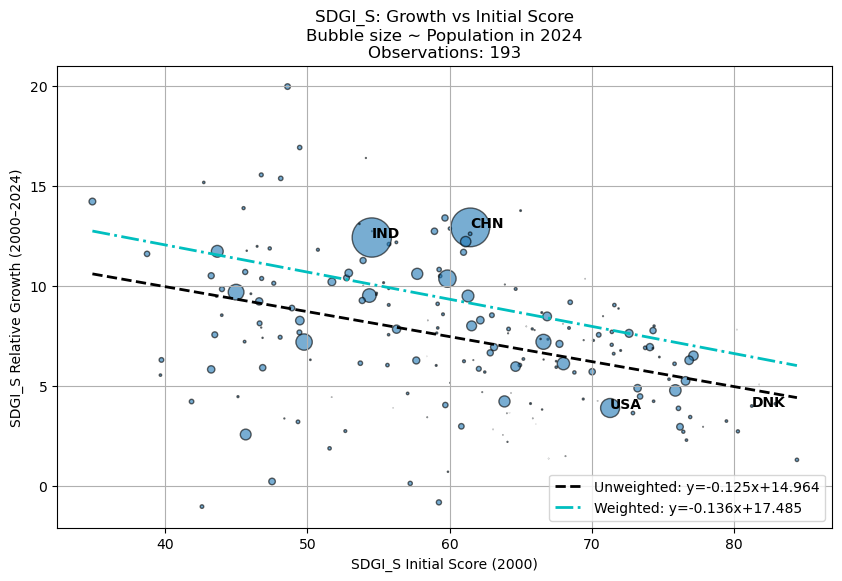

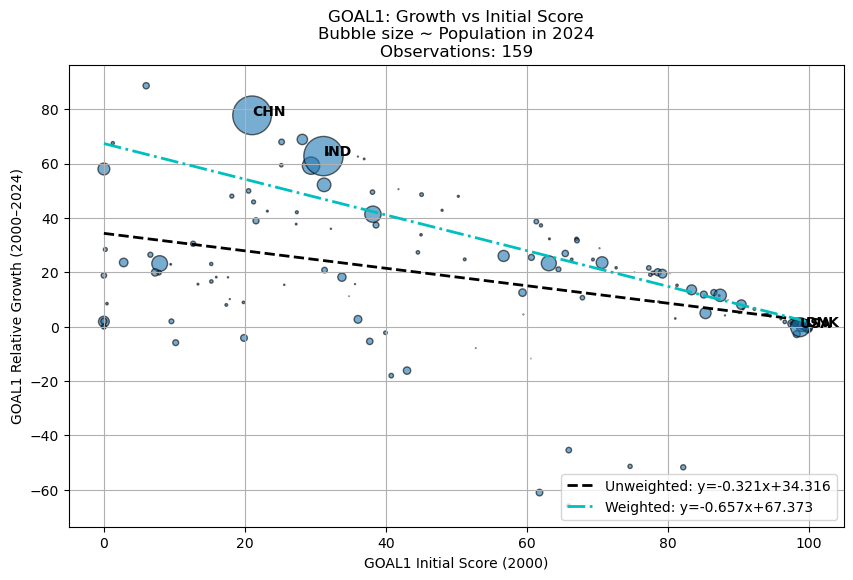

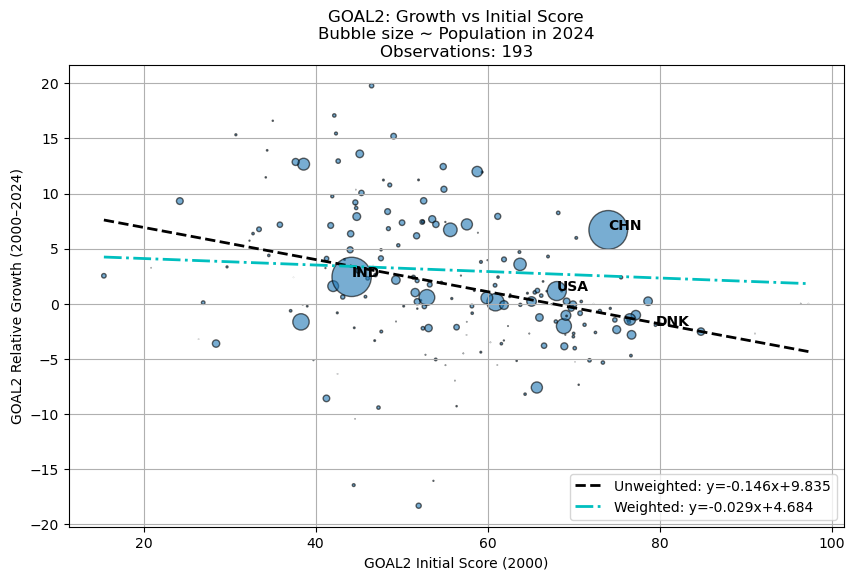

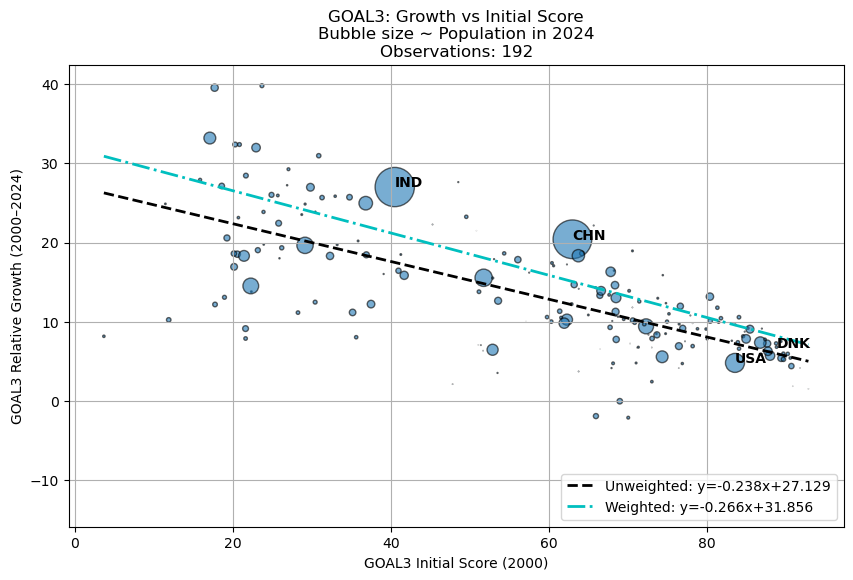

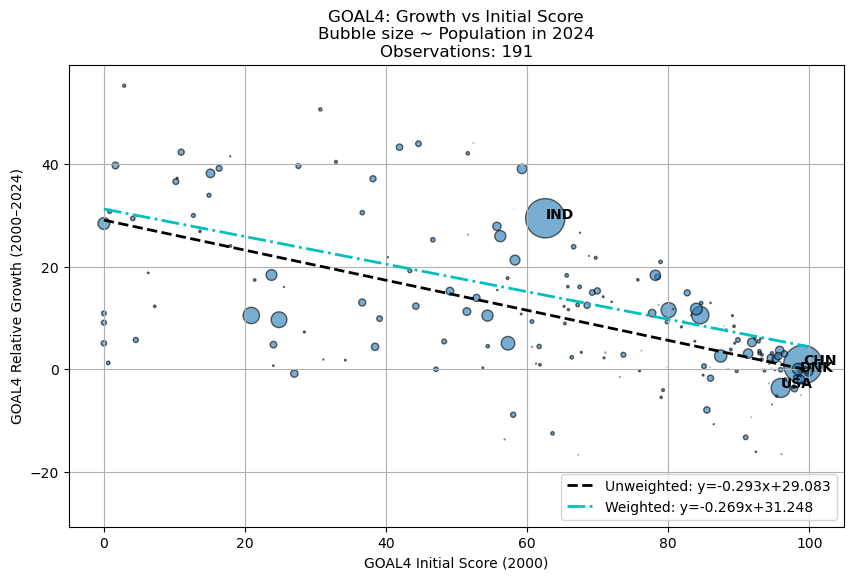

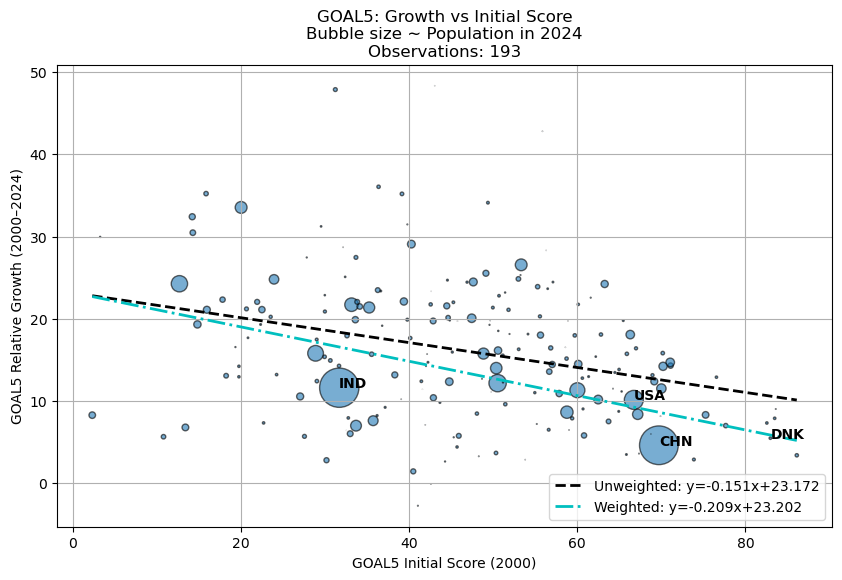

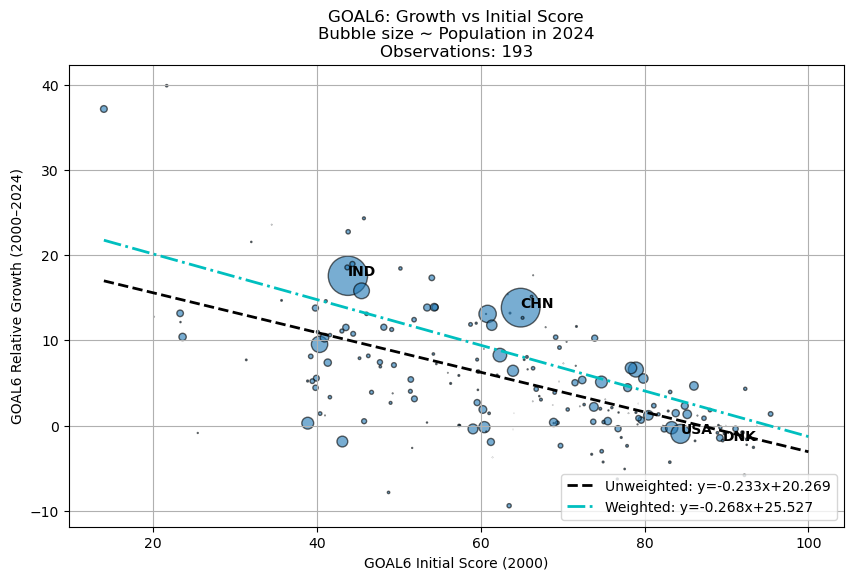

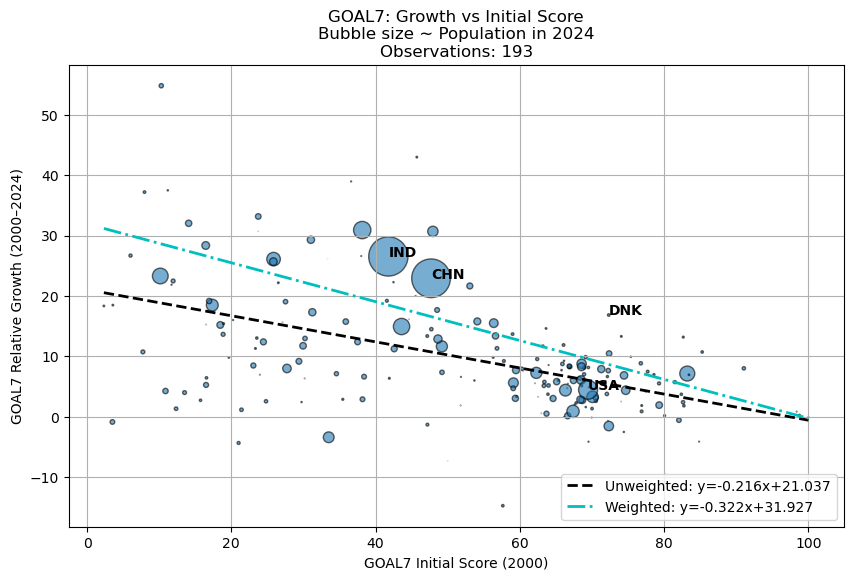

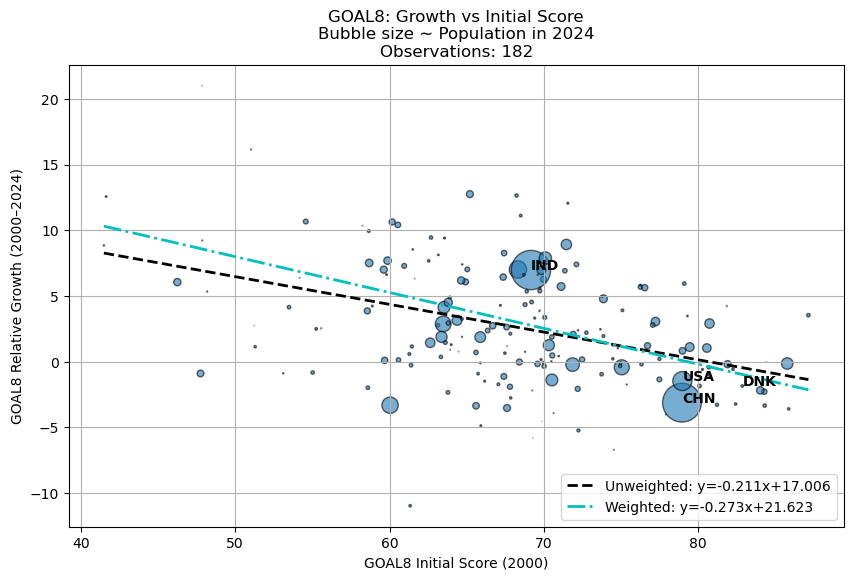

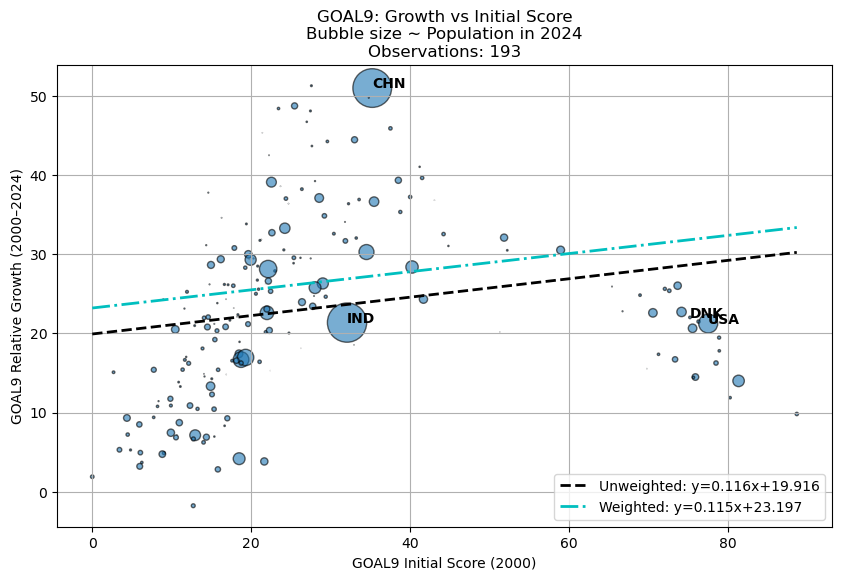

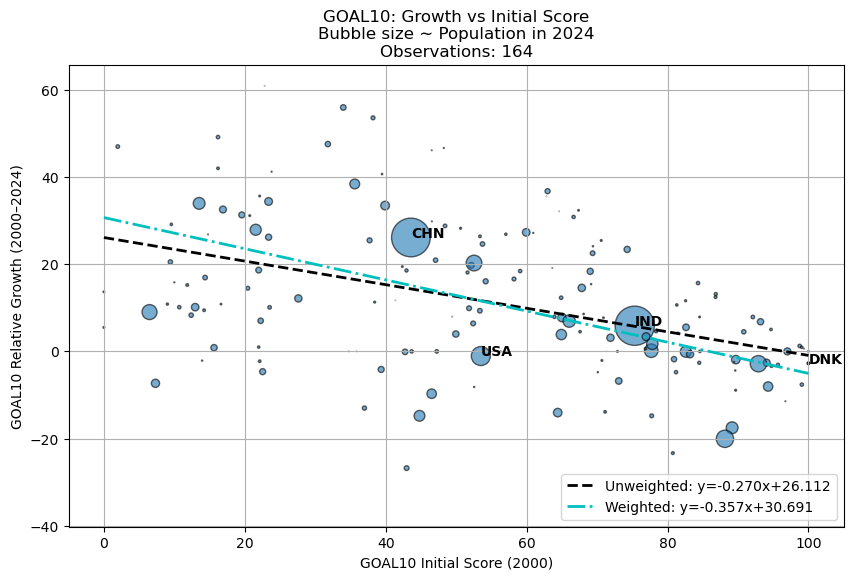

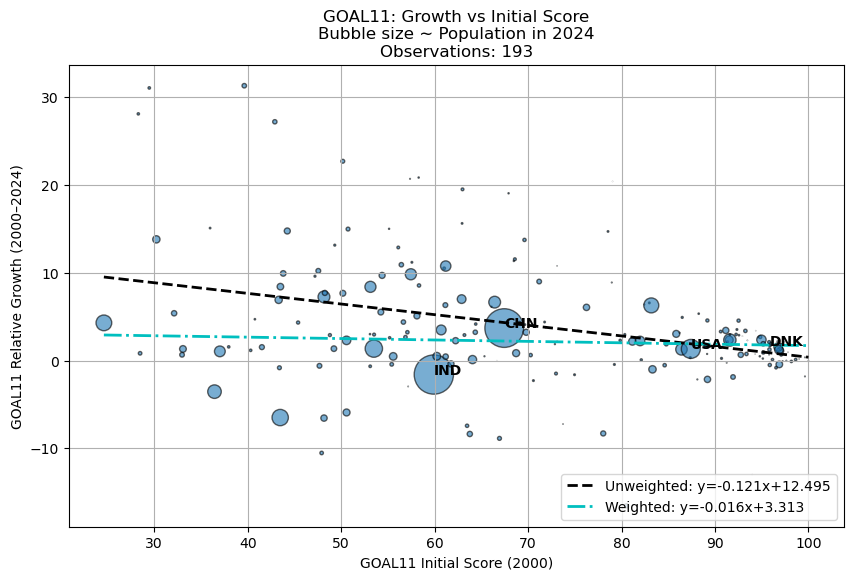

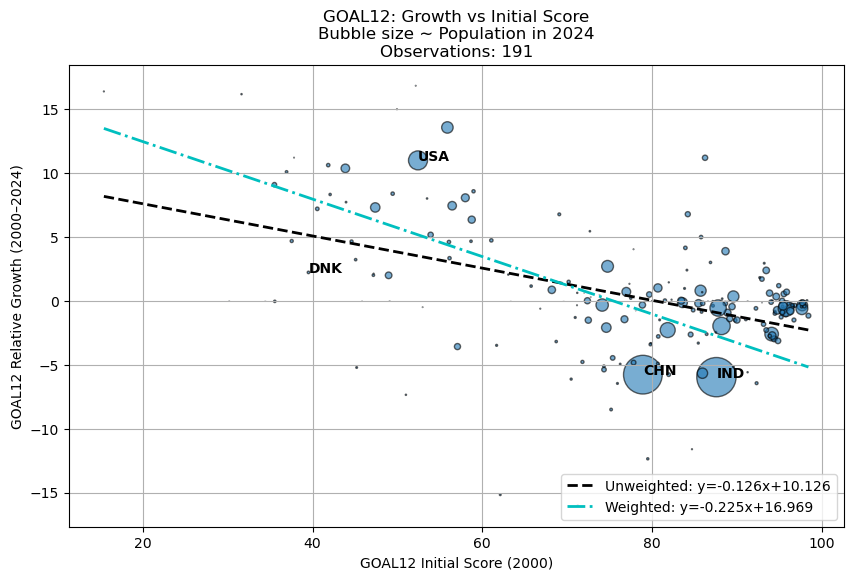

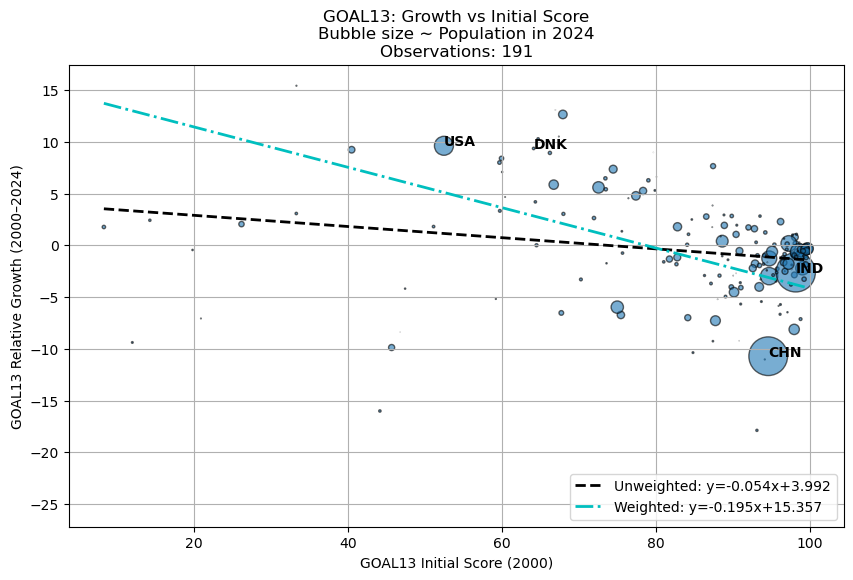

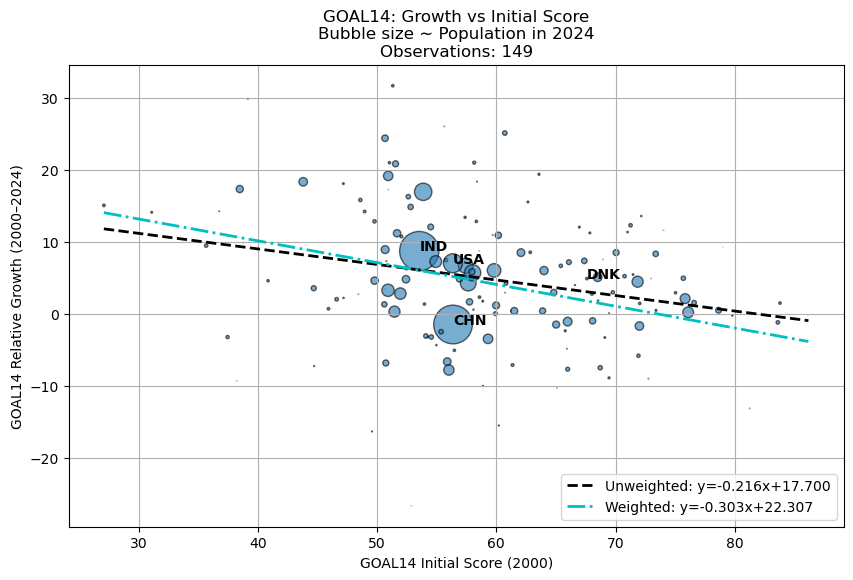

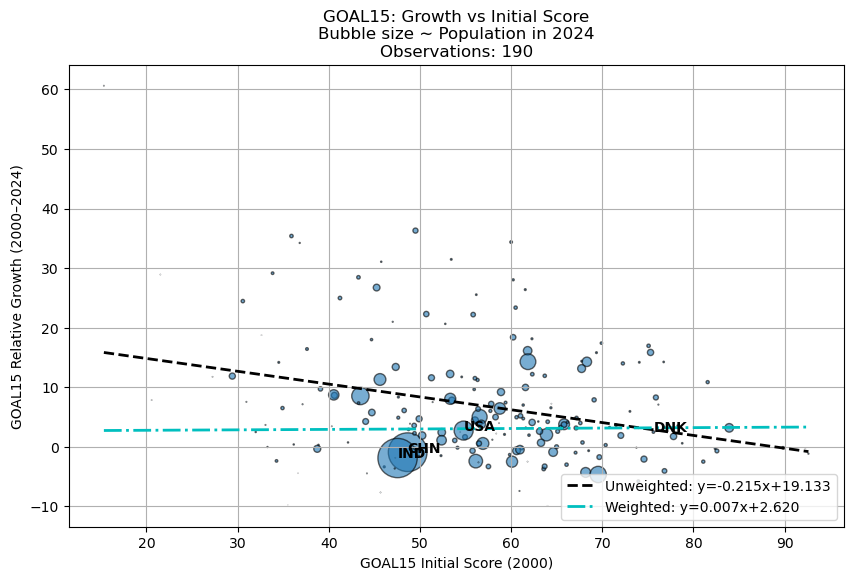

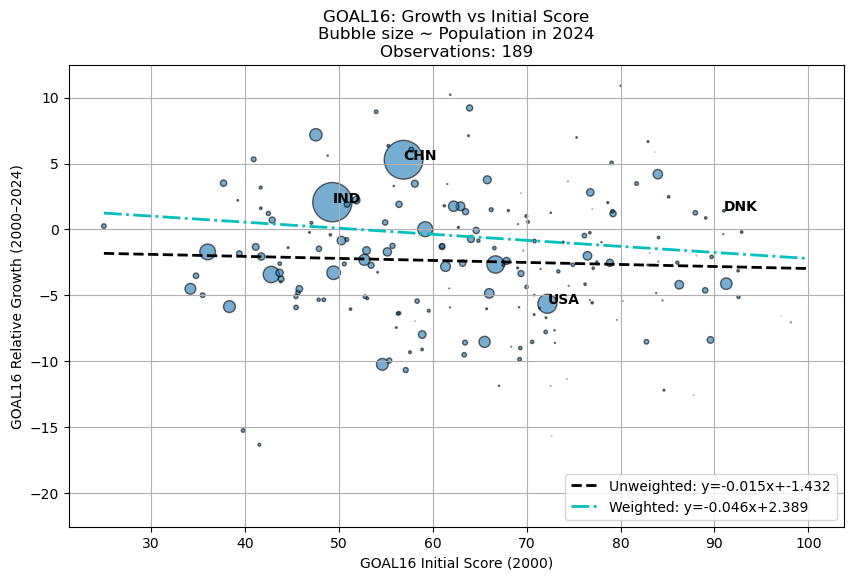

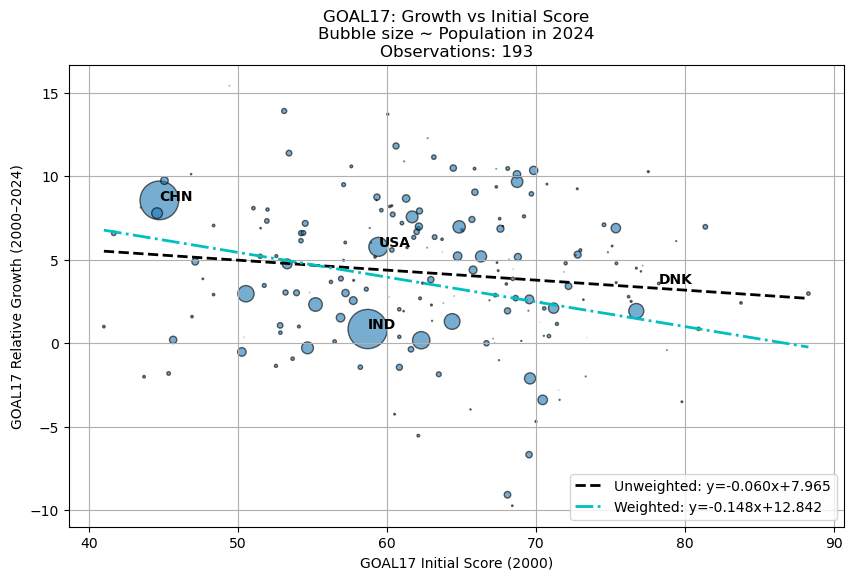

In [28]:
# --- Define which goals to loop over ---
goals = ["sdgi_s"] + [f"goal{i}" for i in range(1, 18)]

# Example: highlight some countries
highlight_ids = ["CHN", "IND", "USA","DNK"]

# Loop over all goals and plot
for g in goals:
    plot_growth_vs_initial(summary,
                           goal=g,
                           highlight_ids=highlight_ids,
                           color_by_region=False,
                           region_to_code=region_to_code,
                           region_categories=region_categories,
                           scale_by_population=False,
                           show_weighted=False)
